In [1]:
%matplotlib inline

FuturesData object with 38 instruments
['CORN', 'LEANHOG', 'LIVECOW', 'SOYBEAN', 'WHEAT', 'KR10', 'KR3', 'BOBL', 'BTP', 'BUND', 'OAT', 'SHATZ', 'US10', 'US2', 'US20', 'US5', 'V2X', 'VIX', 'KOSPI', 'AEX', 'CAC', 'SMI', 'NASDAQ', 'SP500', 'AUD', 'EUR', 'GBP', 'JPY', 'MXP', 'NZD', 'COPPER', 'GOLD', 'PALLAD', 'PLAT', 'CRUDE_W', 'GAS_US', 'EDOLLAR', 'EUROSTX']
2016-11-07    98.5600
2016-11-08    98.5100
2016-11-09    98.2950
2016-11-10    98.1600
2016-11-11    98.1175
Name: price, dtype: float64
1997-09-10    1047.6725
1997-09-11    1040.6725
1997-09-12    1056.6725
1997-09-15    1054.6725
1997-09-16    1078.6725
1997-09-17    1078.6725
1997-09-18    1080.6725
1997-09-19    1083.6725
1997-09-22    1088.6725
1997-09-23    1084.6725
1997-09-24    1077.6725
1997-09-25    1069.6725
1997-09-26    1075.6725
1997-09-29    1084.6725
1997-09-30    1076.6725
1997-10-01    1086.6725
1997-10-02    1091.6725
1997-10-03    1097.6725
1997-10-06    1104.6725
1997-10-07    1112.6725
1997-10-08    1105.6725


/home/chris/src/pysystemtrade/sysdata/data.py:58: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  dailyprice = instrprice.resample("1B", how="last")
/home/chris/src/pysystemtrade/examples/introduction/asimpletradingrule.py:79: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  price = price.resample("1B", how="last")
/home/chris/src/pysystemtrade/examples/introduction/asimpletradingrule.py:87: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,span=32,ignore_na=False,adjust=True).mean()
  fast_ewma = pd.ewma(price, span=Lfast)
/home/chris/src/pysystemtrade/examples/introduction/asimpletradingrule.py:88: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=0,span=128,ignore_na=False,adjust=True).mean()
  slow_ewma = pd.ewma(price, span=Lslow)
/home/c

2016-11-07    0.100716
2016-11-08   -0.011247
2016-11-09   -0.237658
2016-11-10   -0.513974
2016-11-11   -0.835147
Freq: B, dtype: float64


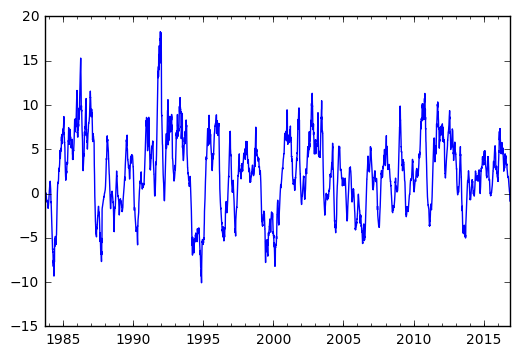

/home/chris/src/pysystemtrade/syscore/algos.py:136: FutureWarning: pd.ewm_std is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(min_periods=10,span=35,ignore_na=False,adjust=True).std(bias=False)
  vol = pd.ewmstd(x, span=days, min_periods=min_periods)
/home/chris/src/pysystemtrade/syscore/algos.py:143: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=500,min_periods=100,center=False).quantile(quantile=0.05)
  vol, floor_days, floor_min_quant, floor_min_periods)
/home/chris/src/pysystemtrade/syscore/accounting.py:555: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  daily_returns = returns_df.resample("1B", how="sum")
/home/chris/src/pysystemtrade/syscore/accounting.py:556: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  weekly_returns = returns_df.resample("W", how="sum")
/hom

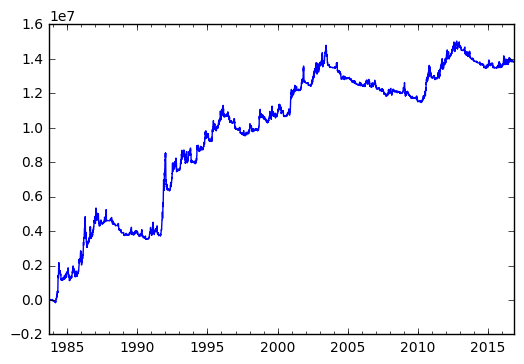

[[('min', '-7.911'), ('max', '5.22'), ('median', '0'), ('mean', '0.01602'), ('std', '0.515'), ('skew', '-0.5705'), ('ann_mean', '4.102'), ('ann_std', '8.24'), ('sharpe', '0.4978'), ('sortino', '0.5583'), ('avg_drawdown', '-11.93'), ('time_in_drawdown', '0.9735'), ('calmar', '0.1237'), ('avg_return_to_drawdown', '0.3439'), ('avg_loss', '-0.3289'), ('avg_gain', '0.3399'), ('gaintolossratio', '1.033'), ('profitfactor', '1.118'), ('hitrate', '0.5195'), ('t_stat', '2.891'), ('p_value', '0.003851')], ('You can also plot / print:', ['rolling_ann_std', 'drawdown', 'curve', 'percent', 'cumulative'])]


/home/chris/src/pysystemtrade/syscore/pdutils.py:224: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=8645,min_periods=1,center=False).max()
  maxx = pd.rolling_max(x, len(x), min_periods=1)
/home/chris/src/pysystemtrade/syscore/pdutils.py:224: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=8645,min_periods=1,center=False).max()
  maxx = pd.rolling_max(x, len(x), min_periods=1)


In [2]:
run asimpletradingrule.py